# Train SHA-RNN language model on WT103

First of all, there are quite a few things the SHA-RNN code needs, so let's install them. Note that we build Apex from source, it will take time.

In [1]:
!git clone https://github.com/Smerity/sha-rnn.git
!git clone https://github.com/NVIDIA/apex
!cd apex && CUDA_HOME="/usr/local/cuda-10.1" pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
!git clone https://github.com/Smerity/pytorch-lamb.git
!cd pytorch-lamb && pip install .
!mv sha-rnn sharnn

In [2]:
import os
import torch
from torch import nn
from fastai.text import *
from fastai.callbacks import *

In [3]:
DATA_PATH = os.path.join(".", "sha_rnn")

In [4]:
wt = untar_data(URLs.WIKITEXT)

In [5]:
train = pd.read_csv(wt/"train.csv", header=None)
test = pd.read_csv(wt/"test.csv", header=None)

In [6]:
train["is_valid"] = False
test["is_valid"] = True
df = pd.concat([train, test])

In [7]:
data = TextList.from_df(df, path=DATA_PATH).split_from_df(col=1).label_for_lm().databunch(bs=64)

In [8]:
vocab_size = len(data.train_ds.x.vocab.itos)

In [9]:
from sharnn.model import SHARNN

This is a wrapper that only does one two things: goes from batch-frst to seqlen-first data arrangement, and stores hidden states. Otherwise, it is a very thin layer between the original SHA-RNN and fastai.

In [10]:
class SHARNNWrapper(nn.Module):
    """
    Making things work without tinkering with code of either project
    """
    def __init__(self, sharnn_params):
        super().__init__()
        self.sharnn = SHARNN(**sharnn_params)
        self.hidden = None
        self.mems = None

    def forward(self, input):
        # the original SHA-RNN is seqlen-first, unlike fastai
        input = input.t()
        h, new_hidden, new_mems, _, _ = self.sharnn(input, hidden=self.hidden, 
                                              mems=self.mems, return_h=True)

        self.hidden = to_detach(new_hidden, cpu=False)
        self.mems = to_detach(new_mems, cpu=False)
        
        # back to batch-first
        output = [h.permute(1, 0, 2)]
        # I don't think something really uses raw_outputs in fastai. These outputs
        # have already went through dropout:
        # https://github.com/Smerity/sha-rnn/blob/218d748022dbcf32d50bbbb4d151a9b6de3f8bba/model.py#L320
        return output, output

In [11]:
# replicating most of the parameters from readme and defaults
params = {
    "rnn_type": "LSTM",
    "ntoken": vocab_size,
    "ninp": 1024,
    "nhid": 4096,
    "nlayers": 4,
    "dropouth": 0.1,
    "dropouti": 0.1,
    "dropout": 0.1,
    "tie_weights": True
}

In [12]:
sharnn = SHARNNWrapper(params)

In [13]:
decoder = LinearDecoder(n_out=vocab_size, n_hid=1024, 
                        tie_encoder=sharnn.sharnn.encoder, output_p=0)

In [14]:
model = SequentialRNN(sharnn, decoder)

Now we can finally assemble the learner!

In [15]:
learn = LanguageLearner(data, model)

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


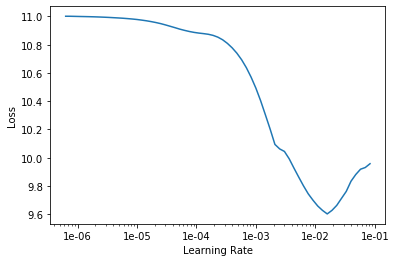

In [17]:
learn.recorder.plot()

In [18]:
learn.fit(5, lr=2e-2, callbacks=[SaveModelCallback(learn)])

In [19]:
learn.save("stage1_final")

In [20]:
learn.load("stage1_final")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (29539 items)
x: LMTextList
xxbos 
  = xxmaj xxunk = 
 
  xxmaj xxunk is a fungal genus in the family xxmaj xxunk , a grouping of mushrooms known collectively as the leathery xxunk . a monotypic genus , it contains the single species xxmaj xxunk multiplex , first described in 1899 , and commonly known as the blue chanterelle , the clustered blue chanterelle , or , in xxmaj alaska , the black chanterelle . xxmaj the distinctive fruit body of this species comprises xxunk to purple - colored clusters of xxunk or spoon - shaped caps with xxunk wrinkles on the undersurface that run down the length of the stem . 
  xxmaj xxunk has had a varied taxonomic history and has been reclassified several times at both the family and genus level . xxmaj the range of xxmaj xxunk includes xxmaj north xxmaj america and eastern xxmaj asia , where xxup p. multiplex may be found growing on the ground in coniferous forests , usually under spruce and fir 

In [21]:
learn.validate()

[3.273967, tensor(0.4085)]

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


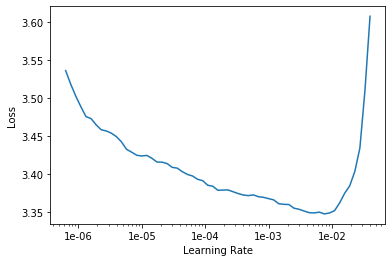

In [23]:
learn.recorder.plot()

In [25]:
learn.fit(3, lr=3e-4, callbacks=[SaveModelCallback(learn, name="stage2")])

epoch,train_loss,valid_loss,accuracy,time
0,3.306725,3.090960,0.428266,7:06:07
1,3.245570,3.076607,0.430530,7:06:26
2,3.180680,3.070377,0.431712,7:05:13


Better model found at epoch 0 with valid_loss value: 3.0909595489501953.
Better model found at epoch 1 with valid_loss value: 3.0766069889068604.
Better model found at epoch 2 with valid_loss value: 3.0703773498535156.


In [26]:
learn.save("stage2_final")

In [16]:
learn.load("stage2_final")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (29539 items)
x: LMTextList
xxbos 
  = xxmaj xxunk = 
 
  xxmaj xxunk is a fungal genus in the family xxmaj xxunk , a grouping of mushrooms known collectively as the leathery xxunk . a monotypic genus , it contains the single species xxmaj xxunk multiplex , first described in 1899 , and commonly known as the blue chanterelle , the clustered blue chanterelle , or , in xxmaj alaska , the black chanterelle . xxmaj the distinctive fruit body of this species comprises xxunk to purple - colored clusters of xxunk or spoon - shaped caps with xxunk wrinkles on the undersurface that run down the length of the stem . 
  xxmaj xxunk has had a varied taxonomic history and has been reclassified several times at both the family and genus level . xxmaj the range of xxmaj xxunk includes xxmaj north xxmaj america and eastern xxmaj asia , where xxup p. multiplex may be found growing on the ground in coniferous forests , usually under spruce and fir 

In [17]:
learn.validate()

[3.0564153, tensor(0.4332)]

In [18]:
learn.export("/workspace/data/sha_rnn/wt_lm_learn.pkl")

In [20]:
vocab = learn.data.vocab

In [22]:
vocab.save("/workspace/data/sha_rnn/wt_lm_vocab.pkl")

In [23]:
learn.save_encoder("/workspace/data/sha_rnn/wt_lm_encoder")